In [56]:
import os
if len(os.getcwd().split('/')) != 8:
    os.chdir('..')

print(os.getcwd())

/Users/rohaan/Desktop/storage/RIT/federated_learning_lab/federated_learning


In [107]:
# Control Variables
train_batch_size = 64
epochs = 3
q = 1e3
checkpoint_interval = 1

In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
import glob

# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [86]:
def set_seed(seed):
    torch.manual_seed(seed)           # For CPU
    torch.cuda.manual_seed(seed)      # For CUDA (if using GPU)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU
    np.random.seed(seed)              # For NumPy
    random.seed(seed)                 # For Python's built-in random
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False     # Turn off optimization for reproducibility

In [87]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

print(f"Datasets:\n\t-> TRAIN: {'available' if len(train_dataset) > 0 else 'N/A'}\n\t-> TEST: {'available' if len(test_dataset) > 0 else 'N/A'}")


Files already downloaded and verified
Files already downloaded and verified
Datasets:
	-> TRAIN: available
	-> TEST: available


In [88]:
train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

print(f"Datasets:\n\t-> TRAIN: {len(train_loader.dataset)} samples\n\t-> TEST: {len(test_loader.dataset)} samples")

Datasets:
	-> TRAIN: 50000 samples
	-> TEST: 10000 samples


In [89]:
def is_kaggle_environment():
    return os.path.exists('/kaggle/')
    
def save_checkpoint(round_num, model, optimizer, save_dir, variables_dict={}, keyword=None):
    # Determine save directory based on environment
    if is_kaggle_environment():
        save_dir = f'/kaggle/working/checkpoints/'
        
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
        
    # Construct filename with optional keyword
    if keyword:
        filename = os.path.join(save_dir, f'checkpoint_{keyword}_round_{round_num}.pth')
    else:
        filename = os.path.join(save_dir, f'checkpoint_round_{round_num}.pth')

    # Save the checkpoint
    variables_dict.update({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'round_num': round_num})
    
    torch.save(variables_dict, filename)
    print(f"Checkpoint created: {filename}")

def load_checkpoint(save_dir, keyword=None):
    # Determine save directory based on environment
    if is_kaggle_environment():
        save_dir = f'/kaggle/working/checkpoints/'
    
    # Search pattern for checkpoint files
    if keyword:
        search_pattern = f'checkpoint_{keyword}_*.pth'
    else:
        search_pattern = 'checkpoint_*.pth'

    checkpoint_files = glob.glob(os.path.join(save_dir, search_pattern))

    if not checkpoint_files:
        print("No checkpoint found, starting from scratch.")
        return None

    # Get the latest checkpoint by creation time
    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)

    # Load the checkpoint
    checkpoint_dict = torch.load(latest_checkpoint)
    print(f"Loaded checkpoint: {latest_checkpoint}")
    
    return checkpoint_dict

In [90]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # kernel_size aka filter size
        # out_channels aka number of filters
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)  # Use ReLU instead of Tanh

        x = nn.functional.max_pool2d(input=x, kernel_size=2, stride=2)  # Use max pooling instead of average pooling

        x = self.conv2(x)
        x = nn.ReLU()(x)  # Use ReLU

        x = nn.functional.max_pool2d(input=x, kernel_size=2, stride=2)  # Use max pooling

        x = self.conv3(x)
        x = nn.ReLU()(x)  # Use ReLU

        x = torch.flatten(x, start_dim=1)  # Flatten the tensor
        

        x = self.fc1(x)
        x = nn.ReLU()(x)  # Use ReLU

        x = self.fc2(x)

        return x

In [91]:
def get_batch_by_idx(train_loader, batch_idx):
    # Calculate start and end indices for the batch
    start_idx = batch_idx * train_loader.batch_size
    end_idx = start_idx + train_loader.batch_size
    
    if end_idx > len(train_loader.dataset):
        end_idx = len(train_loader.dataset)

    # Fetch the data and target tensors for that batch
    data_list, target_list = [], []
    for idx in range(start_idx, end_idx):
        data, target = train_loader.dataset[idx]
        data_list.append(data)
        target_list.append(target)

    # Stack the list into a batch
    data_batch = torch.stack(data_list)
    target_batch = torch.tensor(target_list)

    return data_batch, target_batch

In [92]:
def initialize_model(seed=42):
    set_seed(seed)
    model = LeNet5()
    return model

In [94]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {avg_test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')

    return avg_test_loss, accuracy

In [95]:
def flatten_vector(state_dict, device=device):
    flat_vector = []
    shapes = {}

    for name, tensor in state_dict.items():
        flattened_tensor = tensor.view(-1)  # Flatten the tensor into a 1D vector
        flat_vector.append(flattened_tensor)
        shapes[name] = tensor.shape  # Store the original shape

    # Concatenate all flattened tensors into a single 1D vector
    flat_vector = torch.cat(flat_vector)

    return flat_vector.to(device), shapes

In [96]:
def vector_to_state_dict(flat_vector, shapes):
    reconstructed_state_dict = {}
    current_index = 0

    for name, shape in shapes.items():
        # Calculate the number of elements in the tensor
        num_elements = torch.prod(torch.tensor(shape))
        # Extract the corresponding portion from the flat vector
        flattened_tensor = flat_vector[current_index:current_index + num_elements]
        # Reshape the 1D tensor back to its original shape
        tensor = flattened_tensor.view(shape)
        # Add the tensor back to the state_dict
        reconstructed_state_dict[name] = tensor
        # Update the current index
        current_index += num_elements

    return reconstructed_state_dict

In [97]:
class GA:
    def __init__(self, 
                 seed: int, 
                 d: int, 
                 q: int, 
                 device: torch.device = torch.device("cpu")) -> None:
        self.seed = seed
        self.d = d
        self.q = q
        self.device = device
        torch.manual_seed(self.seed)
        
        print(f'GA initialized with seed={seed}, d={d}, q={q}, device={device}')
        
    def G(self) -> torch.Tensor:
        # Ensure the tensor is created directly on the specified device
        return torch.rand(self.d, self.q, device=self.device)
    
    def w(self, delta: torch.Tensor) -> torch.Tensor:
        GT = self.G().t()  # Transpose the tensor
        return torch.matmul(GT, delta.to(self.device)) / self.q
    
    def delta(self, w: torch.Tensor) -> torch.Tensor:
        return torch.matmul(self.G(), w.to(self.device))

In [98]:
def normalize(tensor: torch.Tensor, min_val: float = 0.0, max_val: float = 1.0) -> torch.Tensor:
    tensor_min = tensor.min()
    tensor_max = tensor.max()
    
    # Scale tensor to range [0, 1]
    normalized_tensor = (tensor - tensor_min) / (tensor_max - tensor_min)
    
    # Scale to desired range [min_val, max_val]
    normalized_tensor = normalized_tensor * (max_val - min_val) + min_val
    
    return normalized_tensor

In [99]:
def train(model, train_loader, optimizer, criterion, batch_idx, device):
    model.train()
    train_loss = 0
    
    # current weights
    w_t = {name: weights.clone().detach().cpu() for name, weights in model.state_dict().items()}
    
    data, target = get_batch_by_idx(train_loader, batch_idx)
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    
    # new weights
    w_t_plus_1 = {name: weights.clone().detach().cpu() for name, weights in model.state_dict().items()}
    updates = {
        name: (w_t[name] - w_t_plus_1[name])
        for name in w_t_plus_1}
    
    return updates, loss

In [112]:
def maintain_last_n_checkpoints(directory, n=10, keyword=None):
    # Construct the search pattern for checkpoint files
    if keyword is not None:
        keyword = '_' + keyword + '_'
    search_pattern = os.path.join(directory, f'checkpoint{keyword}*.pth')
    
    # Find all files matching the pattern
    checkpoint_files = glob.glob(search_pattern)
    
    # Sort files by creation time (oldest first)
    checkpoint_files.sort(key=os.path.getctime)
    
    # Calculate how many files to delete
    files_to_delete = len(checkpoint_files) - n
    
    if files_to_delete > 0:
        # Delete older files
        for i in range(files_to_delete):
            try:
                os.remove(checkpoint_files[i])
                print(f"Deleted old checkpoint: {checkpoint_files[i]}")
            except Exception as e:
                print(f"Failed to delete {checkpoint_files[i]}: {e}")
    else:
        print(f"Total checkpoints ({len(checkpoint_files)}) are within the limit ({n}). No deletion required.")



In [100]:
train_losses = []
test_losses = []
accuracies = []
deltas = []
gws = []
approximation_errors = []

epochs = 3
rounds = len(train_loader) * epochs
print(f"Rounds: {rounds}, Batch Size: {train_loader.batch_size}")

Rounds: 2346, Batch Size: 64


In [101]:
model = initialize_model(seed=1829).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)
model, criterion, optimizer

(LeNet5(
   (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
   (fc1): Linear(in_features=120, out_features=84, bias=True)
   (fc2): Linear(in_features=84, out_features=10, bias=True)
 ),
 CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0.0001
 ))

In [103]:
if is_kaggle_environment():
    save_dir='working/checkpoints'
else:
    save_dir = 'Centralized_CIFAR-10/checkpoints/'
    
os.makedirs(save_dir, exist_ok=True)
save_dir

'Centralized_CIFAR-10/checkpoints/'

In [109]:
checkpoint_dict = load_checkpoint(keyword='test', save_dir=save_dir)
if checkpoint_dict:
    model.load_state_dict(checkpoint_dict['model_state_dict'])
    train_losses = checkpoint_dict['train_losses']
    test_losses = checkpoint_dict['test_losses']
    accuracies = checkpoint_dict['accuracies']
    deltas = checkpoint_dict['deltas']
    gws = checkpoint_dict['gws']
    approximation_errors = checkpoint_dict['approximation_errors']
    optimizer.load_state_dict(checkpoint_dict['optimizer_state_dict'])
    start_round = checkpoint_dict['round_num'] + 1
else:
    start_round = 1  # Start from the first round if no checkpoint is found
start_round, checkpoint_dict

No checkpoint found, starting from scratch.


(1, None)

In [113]:
for round in range(start_round, 1 + rounds):
    print(f"Running round {round}/{rounds}")
    batch_idx = (round % len(train_loader)) % len(train_loader)
    
    updates, loss = train(
        model=model,
        train_loader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        batch_idx=batch_idx,
        device=device
    )

    # apply GA
    updates_flattened, shapes = flatten_vector(updates)

    seed = random.randint(0, 100)
    ga = GA(seed=seed, d=len(updates_flattened), q=int(q), device=device)
    w = ga.w(delta=updates_flattened)
    gw = ga.delta(w=w)

    # Normalize
    gw = normalize(
        tensor=gw, min_val=updates_flattened.min(), max_val=updates_flattened.max()
    )

    # calculate error
    error = updates_flattened - gw
    l2_norm_error = torch.norm(error, p=2)
    approximation_errors.append(l2_norm_error)

    # apply approximated updates
    curr_weights_dict = {
        name: weights.clone().detach().cpu()
        for name, weights in model.state_dict().items()
    }
    curr_weights, _ = flatten_vector(curr_weights_dict)
    new_weights = curr_weights + gw

    new_weights_dict = vector_to_state_dict(flat_vector=new_weights, shapes=shapes)

    model.load_state_dict(state_dict=new_weights_dict)

    avg_test_loss, accuracy = test(
        model, device, test_loader, criterion=criterion
    )

    # for plotting
    train_losses.append(float(loss))
    test_losses.append(avg_test_loss)
    accuracies.append(accuracy)
    deltas.append(updates_flattened)
    gws.append(gw)
    
    # Save checkpoint after every x rounds
    if round % checkpoint_interval == 0:
        save_checkpoint(round_num=round, 
                        model=model, 
                        optimizer=optimizer, 
                        save_dir = 'Centralized_CIFAR-10/checkpoints/', 
                        variables_dict = {
                            'train_losses' : train_losses,
                            'test_losses' : test_losses,
                            'accuracies' : accuracies,
                            'deltas' : deltas,
                            'gws' : gws,
                            'approximation_errors' : approximation_errors
                            }, 
                        keyword='test')
        
    # Maintain only the last 5 checkpoints
    maintain_last_n_checkpoints(directory=save_dir, 
                                n=5, 
                                keyword='test')

Running round 1/2346
GA initialized with seed=77, d=62006, q=1000, device=cpu

Test set: Average loss: 0.0023, Accuracy: 1000/10000 (10%)

Checkpoint created: Centralized_CIFAR-10/checkpoints/checkpoint_test_round_1.pth
Total checkpoints (3) are within the limit (5). No deletion required.
Running round 2/2346
GA initialized with seed=41, d=62006, q=1000, device=cpu

Test set: Average loss: 0.0023, Accuracy: 1000/10000 (10%)

Checkpoint created: Centralized_CIFAR-10/checkpoints/checkpoint_test_round_2.pth
Total checkpoints (3) are within the limit (5). No deletion required.
Running round 3/2346
GA initialized with seed=14, d=62006, q=1000, device=cpu

Test set: Average loss: 0.0023, Accuracy: 1000/10000 (10%)

Checkpoint created: Centralized_CIFAR-10/checkpoints/checkpoint_test_round_3.pth
Total checkpoints (3) are within the limit (5). No deletion required.
Running round 4/2346
GA initialized with seed=55, d=62006, q=1000, device=cpu

Test set: Average loss: 0.0023, Accuracy: 1000/1000

KeyboardInterrupt: 

In [74]:
control_accuracies = []
control_train_losses = []
control_test_losses = []

epochs = 3
rounds = len(train_loader) * epochs
print(f"Rounds: {rounds}, Batch Size: {train_loader.batch_size}")

model = initialize_model(seed=1829).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)

checkpoint_dict = load_checkpoint(keyword='control')
if checkpoint_dict:
    model.load_state_dict(checkpoint_dict['model_state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer_state_dict'])
    control_accuracies = checkpoint_dict['control_accuracies']
    control_train_losses = checkpoint_dict['control_train_losses']
    control_test_losses = checkpoint_dict['control_test_losses']
    start_round = checkpoint_dict['round_num'] + 1
else:
    start_round = 1
    
for round in range(1, 1 + rounds):
    print(f"Running round {round}/{rounds}")
    batch_idx = (round % len(train_loader)) % len(train_loader)

    updates, loss = train(
        model=model,
        train_loader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        batch_idx=batch_idx,
        device=device
    )
    
    avg_test_loss, accuracy = test(
        model, device, test_loader, criterion=criterion
    )

    # for plotting
    control_test_losses.append(loss)
    control_train_losses.append(avg_test_loss)
    control_accuracies.append(accuracy)
    
    # Save checkpoint after every x rounds
    if round % checkpoint_interval == 0:
        save_checkpoint(round_num=round, 
                        model=model, 
                        optimizer=optimizer, 
                        save_dir = 'Centralized_CIFAR-10/checkpoints/', 
                        variables_dict = {
                            'control_test_losses' : control_test_losses,
                            'control_train_losses' : control_train_losses,
                            'control_accuracies' : control_accuracies,
                            }, 
                        keyword='control')

Rounds: 2346, Batch Size: 64
Loaded checkpoint: Centralized_CIFAR-10/checkpoints/checkpoint_control_round_10.pth
Running round 1/2346

Test set: Average loss: 0.0023, Accuracy: 1000/10000 (10%)

Running round 2/2346

Test set: Average loss: 0.0023, Accuracy: 1002/10000 (10%)

Running round 3/2346

Test set: Average loss: 0.0023, Accuracy: 1002/10000 (10%)

Running round 4/2346

Test set: Average loss: 0.0023, Accuracy: 1000/10000 (10%)

Running round 5/2346

Test set: Average loss: 0.0023, Accuracy: 1001/10000 (10%)

Running round 6/2346

Test set: Average loss: 0.0023, Accuracy: 1087/10000 (11%)

Running round 7/2346

Test set: Average loss: 0.0023, Accuracy: 1491/10000 (15%)

Running round 8/2346

Test set: Average loss: 0.0022, Accuracy: 1676/10000 (17%)

Running round 9/2346

Test set: Average loss: 0.0022, Accuracy: 1876/10000 (19%)

Running round 10/2346

Test set: Average loss: 0.0022, Accuracy: 2013/10000 (20%)

Checkpoint created: Centralized_CIFAR-10/checkpoints/checkpoint_co

In [82]:
import pandas as pd
import seaborn as sns
import pandas as pd

# Create a DataFrame
data = {
    'Round': list(range(1, rounds + 1-10)),
    'CIFAR-10 + GA + Norm': accuracies,
    'CIFAR-10' : control_accuracies[:-10]
    }

df_accuracies = pd.DataFrame(data)

df_accuracies


,Round,CIFAR-10 + GA + Norm,CIFAR-10
0,1,10.12,10.00
1,2,13.07,10.02
2,3,14.22,10.02
3,4,16.11,10.00
4,5,17.06,10.01
...,...,...,...
2331,2332,18.36,58.80
2332,2333,18.67,58.73
2333,2334,18.85,58.72
2334,2335,18.87,58.75


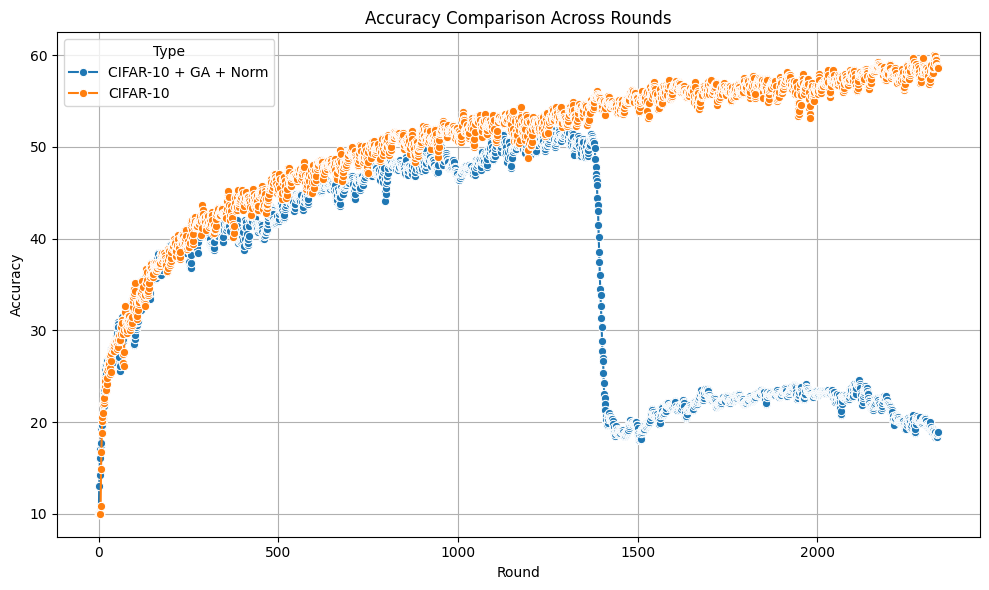

In [83]:
# Melt the DataFrame for easier plotting
df_accuracies_melted = df_accuracies.melt(id_vars='Round', var_name='Type', value_name='Accuracy')

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='Round', y='Accuracy', hue='Type', data=df_accuracies_melted, marker='o')

# Customize plot
plt.title('Accuracy Comparison Across Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend(title='Type')
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
df = pd.DataFrame(data = {
    'delta_1' : [float(x) for x in deltas[0]],
    'delta_2' : [float(x) for x in deltas[1]],
    'delta_3' : [float(x) for x in deltas[2]],
    'Gw_1' : [float(x) for x in gws[0]],
    'Gw_2' : [float(x) for x in gws[1]],
    'Gw_3' : [float(x) for x in gws[2]]
})

df

In [ ]:
# Melt the DataFrame for easier plotting
df_melted = df.melt(var_name='variable', value_name='value')

orange_hex = '#F76902'
blue_hex = '#4c72b0'
# Set the color palette

keys = df.columns.tolist()
palette = {}
for key in keys:
    if 'Gw' in key:
        palette[key] = orange_hex
    else:
        palette[key] = blue_hex


# Create the box plot
plt.figure(figsize=(10, 8))
sns.boxplot(x='variable', y='value', data=df_melted, palette=palette)

# Customize plot
plt.xticks(rotation=0)
plt.title('Box Plots of Data')
plt.xlabel('Variables')
plt.ylabel('Values')

upper_limit = df.delta_1.max() * 1.5
lower_limit = df.delta_1.min() * (1.5 if df.delta_1.min() < 0 else -1.5)
plt.ylim(lower_limit, upper_limit)

# Show plot
plt.tight_layout()
plt.show()